In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from energy_py import Runner
from energy_py.agents import DQN
from energy_py.envs import BatteryEnv

In [2]:
#  set random seeds for repeatability
np.random.seed(42)
tf.set_random_seed(42)

In [3]:
#  define a total number of steps for the experiment to run
TOTAL_STEPS = 400000

agent_config = {'discount': 0.97,                 #  the discount rate
                'tau': 0.01,                     #  parameter that controls the copying of weights from online to target network
                'total_steps': TOTAL_STEPS,   
                'batch_size': 32,                 #  size of the minibatches used for learning
                'layers': (50, 50),               #  structure of the neural network used to approximate Q(s,a)
                'learning_rate': 0.01,          #  controls the stength of weight updates during learning       
                'epsilon_decay_fraction': 0.3,    #  a fraction as % of total steps where epsilon decayed from 1.0 to 0.1
                'memory_fraction': 0.85,           #  the size of the replay memory as a % of total steps
                'memory_type': 'deque',           #  the replay memory implementation we want
                'process_observation': 'standardizer',
                'process_target': 'normalizer'}    

#  we just need to let our env know where our state.csv and observation.csv are (data_path)
env = BatteryEnv(data_path=os.getcwd())

In [4]:
#  Runner is a class that helps us with experiments - tracking rewards, writing environment info to csv and managing TensorBoard
#  in this notebook we just use it to track rewards for us
runner = Runner()

#  initialize Tensorflow machinery
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #  add the tf session and t-+he environment to the agent config dictionary
    #  and initialize the agent
    agent_config['sess'] = sess
    agent_config['env'] = env
    agent = DQN(**agent_config)
    
    #  initial values for the step and episode number
    step, episode = 0, 0

    #  outer while loop runs through multiple episodes
    while step < TOTAL_STEPS:
        episode += 1
        done = False
        observation = env.reset()
        
        while not done:
            step += 1
            action = agent.act(observation)
            
            next_observation, reward, done, info = env.step(action)
            
            #  store the experience
            agent.remember(observation, action, reward,
                           next_observation, done)
            
            #  moving to the next time step
            observation = next_observation
            #  saving the reward 
            runner.append(reward)
            
            #  we don't start learning until the memory is half full
            if step > int(agent.memory.size * 0.5):  #set threshold to start learning
                train_info = agent.learn()
        
        if episode % 200 == 0:
            print('progress - {:.1f}% - episode {:.0f} - run time {:.2f} - episode reward {:.2f} - avg rewards {:.2f}'.format(100*step/TOTAL_STEPS,
                                                                                                                              episode,
                                                                                                                              runner.calc_time(),
                                                                                                                              sum(runner.ep_rewards),
                                                                                                                              runner.avg_rew))
        #  the report method should be run at the end of each episode
        runner.report({'ep': episode,
                       'step': step})

copying ['hidden_layer_1', 'Variable:0'] to ['hidden_layer_1', 'Variable:0']
copying ['hidden_layer_1', 'Variable_1:0'] to ['hidden_layer_1', 'Variable_1:0']
copying ['input_layer', 'Variable:0'] to ['input_layer', 'Variable:0']
copying ['input_layer', 'Variable_1:0'] to ['input_layer', 'Variable_1:0']
copying ['output_layer', 'Variable:0'] to ['output_layer', 'Variable:0']
copying ['output_layer', 'Variable_1:0'] to ['output_layer', 'Variable_1:0']
progress - 2.4% - episode 200 - run time 0.21 - episode reward -17.65 - avg rewards -19.47
progress - 4.7% - episode 400 - run time 0.38 - episode reward -3.78 - avg rewards -19.15
progress - 7.0% - episode 600 - run time 0.53 - episode reward -23.36 - avg rewards -18.77
progress - 9.4% - episode 800 - run time 0.68 - episode reward -22.94 - avg rewards -20.85
progress - 11.8% - episode 1000 - run time 0.85 - episode reward -19.61 - avg rewards -20.93
progress - 14.1% - episode 1200 - run time 1.08 - episode reward -28.76 - avg rewards -24.

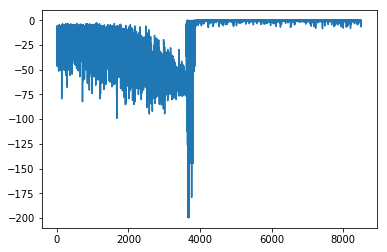

In [6]:
#  plot rewards

import matplotlib.pyplot as plt

episode_rewards = runner.global_rewards
plt.plot(episode_rewards)

In [7]:
#  we can also look at what happened in our last episode
ep_hist = pd.DataFrame.from_dict(info)
fd = pd.DataFrame.from_dict(info)

fd.columns = ['action','done','cpu_utilization','gross_rate','losses','net_stored','new_rate','next_observation','next_state','observation','old_rate','reward','state','steps']
fd =fd.drop('done',1)
#fd.columns = ['action', 'done','cpu_util']
fd.head()
#print(fd['done'],fd['action'])
#ep_hist.head()

,action,cpu_utilization,gross_rate,losses,net_stored,new_rate,next_observation,next_state,observation,old_rate,reward,state,steps
0,"[1.894736842105263, 2.0]",48.366667,0.0,0.0,0.0,0.0,"[[50.0, 50.0, 50.0, 100.0, 100.0, 1.0, 1.0, 0.0]]","[[48.7, 0.0]]","[[50.0, 50.0, 50.0, 50.0, 100.0, 0.0, 1.0, 0.0]]",0.0,-0.0,"[[48.36666667, 0.0]]",1
1,"[0.631578947368421, 1.1578947368421053]",48.700000,0.0,0.0,0.0,0.0,"[[50.0, 50.0, 100.0, 100.0, 100.0, 2.0, 1.0, 0...","[[48.4, 0.0]]","[[50.0, 50.0, 50.0, 100.0, 100.0, 1.0, 1.0, 0.0]]",0.0,-0.0,"[[48.7, 0.0]]",2
2,"[1.263157894736842, 1.5789473684210527]",48.400000,0.0,0.0,0.0,0.0,"[[50.0, 100.0, 100.0, 100.0, 100.0, 3.0, 1.0, ...","[[48.33333333, 0.0]]","[[50.0, 50.0, 100.0, 100.0, 100.0, 2.0, 1.0, 0...",0.0,-0.0,"[[48.4, 0.0]]",3
3,"[0.21052631578947367, 0.5263157894736842]",48.333333,0.0,0.0,0.0,0.0,"[[100.0, 100.0, 100.0, 100.0, 100.0, 4.0, 1.0,...","[[48.53333333, 0.0]]","[[50.0, 100.0, 100.0, 100.0, 100.0, 3.0, 1.0, ...",0.0,-0.0,"[[48.33333333, 0.0]]",4
4,"[0.21052631578947367, 0.5263157894736842]",48.533333,0.0,0.0,0.0,0.0,"[[100.0, 100.0, 100.0, 100.0, -50.0, 5.0, 1.0,...","[[48.16666667, 0.0]]","[[100.0, 100.0, 100.0, 100.0, 100.0, 4.0, 1.0,...",0.0,-0.0,"[[48.53333333, 0.0]]",5


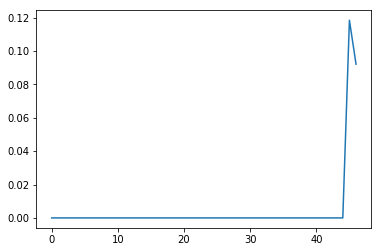

In [8]:
#plt.plot(ep_hist.loc[:, 'new_charge'])
plt.plot(fd.loc[:, 'new_rate'])


Loss function


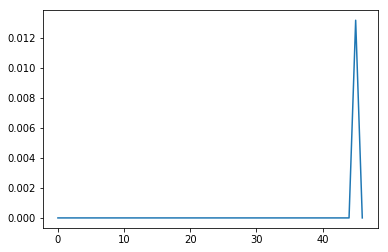

In [9]:
print('Loss function')
plt.plot(fd.loc[:, 'losses'])

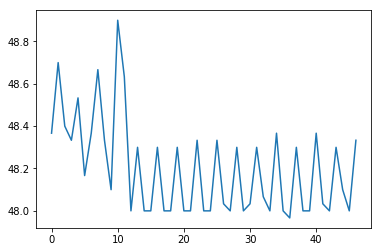

In [10]:
#plt.plot(ep_hist.loc[:, 'electricity_price'])
plt.plot(fd.loc[:, 'cpu_utilization'])

In [11]:
ep_hist.loc[:, 'reward'].sum()

-5.0438596492105265

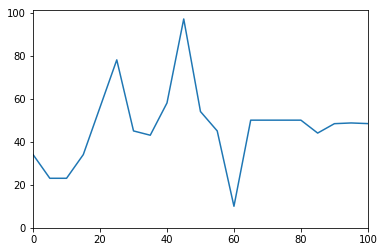

,Time,CPU
0,0.0,34.0
1,5.0,23.0
2,10.0,23.0
3,15.0,34.0
4,20.0,56.0


In [12]:
df1=pd.read_excel('C:\\Users\\DELL\\Anaconda3\\cloud2may\\state1.xlsx')
plt.plot(df1['Time'],df1['CPU'])
ax=plt.gca()
ax.set_ylim([0,101])
ax.set_xlim([0,100])
plt.show()
df1.head()